#  Correlation and uncertainties -- Two approaches

Marty Ligare, August 2020

## Introduction

Consider the oft-encountered problem of calibrating an instrument.  To be specific, let's consider the simple case in which you are calibrating a spectrometer, using a set of 
spectral lines with known wavelengths $\lambda_i$. You measure the pixel number $p_i$ on the CCD array of the spectrometer for each of the lines, and each of these measurements has an associated uncertainty $\sigma_i$ (uncertainties in the known wavelenths is assumed to be negligible).  Let's also assume that a preliminary analysis suggests that  data is well-modeled by a linear relationship between $\lambda$ and $p$ (it's straightforward to generalize to more complicated relationships).

In an experiment in which this calibration data is to be used, the value of the pixel number  measured for a spectral line of unkown wavelength.  Let's call the measured value of the pixel number for this unknown line $p^\ast$, and the associated uncertainty $\alpha^\ast$.  

The question is:  How do we determine the best value, <b>including the uncertainty</b>, for the unknown wavelength $\lambda^\ast$?

#### Naive (<span style="color:red">and <i>incorrect</i></span> ) approach:

Since there is good evidence for a linear relationship between $p$ and $\lambda$, why not
simply fit $\lambda$ as a function of $p$, and use the linear relationship: 

$$
\Large
\lambda^\star = \mbox{slope}\times p^\star + \mbox{intercept}\quad?
$$

Whle this approach can give a "quick and dirty" <b>estimate</b> for $\lambda^\ast$, it is fundamentally flawed. All of the standard fitting routines we have used are based on the assumption that the uncertainties are all in the dependent variable. They can't be expected to handle uncertainties in the independent variable corrrectly, and they can't  give any information about the uncertainty in the slope, the intercept or $\lambda^\ast$. 

#### Discussion of better approach, and correlated uncertainties

To get good information about the relationship between $\lambda$ and $p$ we should
fit the function

$$ 
\Large
p = m\lambda + b  
$$

to find values of $m$ and $b$, and then invert this function to find

$$
\Large
\lambda^\ast = \frac{1}{m}(p^\ast - b).   
$$

In determining the uncertainty $\sigma^\ast$ in the measurement of the unknown wavelength
there is an additional complication: the values of $m$ and $b$ determined by the fitting function are <em>correlated</em>.  To understand correlation, consider the following cartoon.

![title](correlation.png)

The fact that there is an uncertainty in the slope and the intercept of the best-fit line is captured in the graphic by the fact that there is a range of "reasonable" lines from which we determine the "best" by minimizing the $\chi^2$ statistic.  In looking at the illustrated
extreme cases of "reasonable" lines, we see that the teal line has a low slope, but a relatively high intercept, while the purple line has a high slope, but a relatively low intercept.  It is extremely unlikely that the data is fit by a line with a slope as large as that of the purple line, <em>and</em> an intercept as large as the teal line; such a line would lie above all of 
the data points.  It is in this sense that the uncertainties in the slope and intercept are said to be <em>correlated</em>.

One other feature to deduce from the cartoon is that a measurement of a pixel value $p^\ast$
for the unkown spectral line near 1100 will give a relatively small range of "reasonable"
values for $\lambda^\star$, while a $p^\ast$ measurement of 1300 will give a <em>much</em> 
larger uncertainty in $\lambda^\star$.

In this notebook we will explore two approaches to the quantitative determination of the 
uncertainty in values of the wavelength $\lambda^\star$ using a model data set.
- In the first approach we will use Monte Carlo methods to simulate data sets that are 
<em>statistically equivalent</em> to the calibration data.  We won't use any 
propagation-of-errors rules, or combination-of-uncertainty rules; we'll just simulate lots of "experiments" and look at the spread in the outcomes.
- In the second approach we show how to generalize things when simple rules for uncorrelated uncertainties break down.  For example, when uncertainties are correlated,

$$ 
\Large
\alpha_\text{total} \neq \sqrt{\alpha_1^2 + \alpha_2^2 + \alpha_3^2 +\dots}.   
$$

Simple cases of how to handle correlated uncertainties are discussed in Section 7.3 of Hughes and Hase.  In this notebook we will use a computer to calculate autmatically quantities like those given in Table 7.2 using information returned by the `optimize.curve_fit` function.

<span style="color:red">NOTE:</span> In the notebook below I make the transition from wavelength and pixel to the more general $x$ and $y$:

$$ \lambda \longrightarrow \verb+x+,\quad p \longrightarrow \verb+y+,\quad \alpha_p\longrightarrow \verb+u+ $$
$$ p^\star \longrightarrow \verb+ystar+, \quad \alpha_{p^\star} \longrightarrow \verb+uystar+ $$


## Imports and Function Definitions

In [1]:
import numpy as np
from scipy import optimize
from scipy import stats

import numdifftools as nd # Module for numerical evaluation of derivatives
                          # Installed on Bucknell linux network
                          # To install on other computers: 
                          #     pip install numdifftools

import matplotlib as mpl 
import matplotlib.pyplot as plt

In [2]:
# Following is an Ipython magic command that puts figures in notebook.
%matplotlib notebook
        
# M.L. modifications of matplotlib defaults
# Changes can also be put in matplotlibrc file, 
# or effected using mpl.rcParams[]
mpl.style.use('classic') 
plt.rc('figure', figsize = (6, 4.5)) # Reduces overall size of figures
plt.rc('axes', labelsize=16, titlesize=14)
plt.rc('figure', autolayout = True)  # Adjusts supblot params or new size

#### Define linear function

In [3]:
def f(x,m,b):
    return x*m + b

## Linear fit to data for $m$ and $b$

#### Data to be fit:

In [4]:
# Or: data = np.loadtxt("file.dat")  
# Format:  [[x1,y1,u1], [x2,y2,u2], ... ]   where u1 is uncertainty in y1
data = np.array([[1, 2.947032612427293, 0.5],
 [2, 6.168779380682309, 0.5],
 [3, 7.1618838821688, 0.5],
 [4, 9.590549514954866, 0.5],
 [5, 11.20657, 0.5]])
x = data.T[0]  # separate x values into single array
y = data.T[1]  # separate y alues into single array
u = data.T[2]  # separate uncertainties into single array

ystar = 3.9    # measurement of "unknown" (pixel) 
uystar = 0.5   # uncertainty in "unknown"

<IPython.core.display.Javascript object>


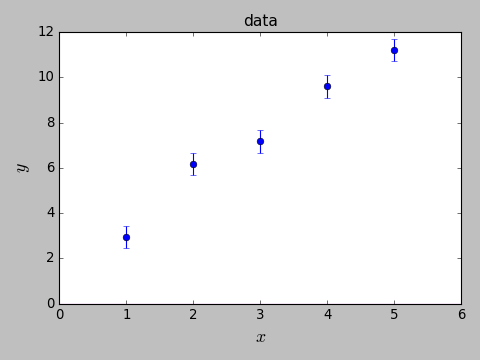

In [5]:
plt.figure()
xfine = np.linspace(0,6,201) # quasi-continuous set of x's function plot
plt.title("data",fontsize=14)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.axhline(0,color='magenta')
plt.xlim(0,6) 
plt.errorbar(x,y,yerr=u,fmt='o');

#### Perform fit

In [6]:
popt, pcov = optimize.curve_fit(f, x, y, sigma=u, absolute_sigma=True)

slope = popt[0]
intercept = popt[1]

print("slope =", slope,"+/-", np.sqrt(pcov[0,0]))
print("intercept =", intercept,"+/-", np.sqrt(pcov[1,1]),"\n")

print("covariance matrix =", pcov, "\n")
pcov_data = pcov

chi2 = np.sum((y - f(x, *popt))**2/u**2)

print("chi2 =",chi2)
print("reduced chi2 = chi2/(5-2) =",chi2/3)


slope = 1.994084490943965 +/- 0.15811389158461894
intercept = 1.4327096052222066 +/- 0.5244044422749461 

covariance matrix = [[ 0.025      -0.07500001]
 [-0.07500001  0.27500002]] 

chi2 = 3.700621429959703
reduced chi2 = chi2/(5-2) = 1.2335404766532343


<IPython.core.display.Javascript object>


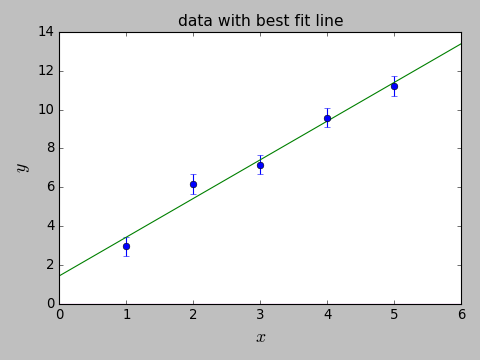

In [7]:
plt.figure()
xfine = np.linspace(0,6,201) # quasi-continuous set of x's for function plot
plt.title("data with best fit line")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.axhline(0,color='magenta')
plt.xlim(0,6)  # Pad x-range on plot
plt.errorbar(x,y,yerr=u,fmt='o');
plt.plot(xfine,f(xfine,slope, intercept));

#### Residuals:

<IPython.core.display.Javascript object>


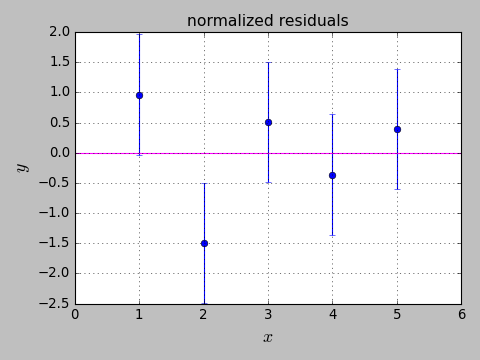

In [8]:
plt.figure()
plt.axhline(0,color='magenta')
plt.title('normalized residuals',fontsize=14)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(0,6)
plt.grid(True)
plt.errorbar(x,(f(x,slope,intercept)-y)/u, yerr=1, fmt='o');

### Results from linear fitting

#### Value for "unknown": 

$$
\Large
\quad x^\ast = \frac{1}{m}(y^\ast - b)   
$$

In [9]:
b, m = intercept, slope   # For use later
xstar = (ystar - intercept)/slope 
print("unknown 'wavelength' =",xstar,"+/- ?")

unknown 'wavelength' = 1.2373048413860441 +/- ?


#### <span style="color:red">The fitting function does not give a value for the uncertainty in $x^\ast$.</span> 

## Uncertainties I: Monte Carlo approach 

"Offered the choice between the mastery of a five-foot shelf of analytical statistics books and middling ability at performing statistical Monte Carlo simulations, we would surely choose to have the latter skill."<br><br>
<em>Numerical Recipes</em>, W. Press, B. Flannery, S. Teukolsky, and W. Vetterling<br>

In this section we will first redo the determination of the uncertainties in $m$ and $b$ using a Monte Carlo technique.  We will then exted this technique to determine the uncertainty in the "unknown" $x^\ast$ (corresponding to the wavelength of the unknown spectral line).

#### We can generate a simulated data set that is <em>statistically equivalent</em> to the original data set (assuming the model is correct)

In [10]:
ySim = stats.norm.rvs(slope*x + intercept,u)
y,ySim

(array([ 2.94703261,  6.16877938,  7.16188388,  9.59054951, 11.20657   ]),
 array([ 3.36827933,  4.8082964 ,  6.46126342,  9.5749931 , 11.85627006]))

#### Do this many times, fit each of the simulated data sets, and collect the values of $b$ and $m$.

In [11]:
nSim = 10000         # Number of simulated data sets
mSim = np.array([])  # Array for simulated slopes
bSim = np.array([])   # Array for simulated intercepts

for i in range(nSim):
    ySim = stats.norm.rvs(slope*x+intercept,u) # Generate simulated data
    popt, pcov = optimize.curve_fit(f, x, ySim, sigma=u, absolute_sigma=True) # Fit simulated data
    bSim = np.append(bSim, popt[1])      # Record intercept
    mSim = np.append(mSim, popt[0])      # Record slope

#### Correlation of $b$ and $m$ evident in "tilt" of graph below 

<IPython.core.display.Javascript object>


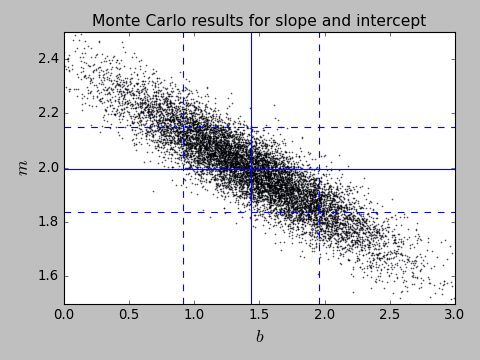

In [12]:
plt.figure()
plt.title("Monte Carlo results for slope and intercept",fontsize=14)
plt.xlabel("$b$")
plt.ylabel("$m$")
plt.xlim(0,3)
plt.ylim(1.5,2.5)
plt.axhline(np.mean(mSim))
plt.axhline(np.mean(mSim) + np.std(mSim),linestyle='--')
plt.axhline(np.mean(mSim) - np.std(mSim),linestyle='--')
plt.axvline(np.mean(bSim))
plt.axvline(np.mean(bSim) + np.std(bSim),linestyle='--')
plt.axvline(np.mean(bSim) - np.std(bSim),linestyle='--')
plt.scatter(bSim,mSim,marker='.',s=0.5);

#### For fun, we can add $\chi^2$ contours to Monte Carlo data

In [13]:
# Set grid in intercept-slope space for evaluation of chi-square
mcB = np.linspace(0, 3.0, 101)
mcM = np.linspace(1.6, 2.4, 101)
B, M = np.meshgrid(mcB, mcM)

# Evaluate chi-square at every grid point and subtract minimum value
Z = np.zeros((len(B),len(B[0])))
for i in range(len(B)):
    for j in range(len(B[0])):
        Z[i,j] = (np.sum((f(x,M[i,j],B[i,j])-y)**2/u**2)-chi2)

<IPython.core.display.Javascript object>


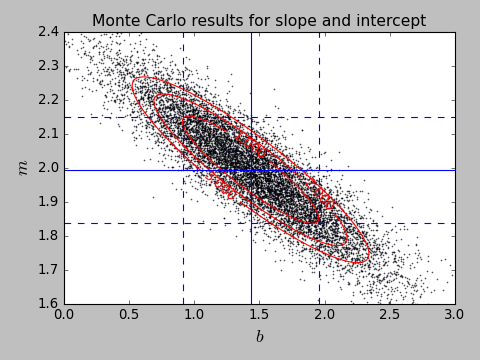

In [14]:
plt.figure()
CS = plt.contour(B, M, Z, levels=[1,2,3], colors="r")
plt.title("Monte Carlo results for slope and intercept",fontsize=14)
plt.xlabel("$b$")
plt.ylabel("$m$")
plt.xlim(0,3)
plt.ylim(1.6,2.4)
plt.axhline(np.mean(mSim))
plt.axhline(np.mean(mSim)+np.std(mSim),linestyle='--')
plt.axhline(np.mean(mSim)-np.std(mSim),linestyle='--')
plt.axvline(np.mean(bSim))
plt.axvline(np.mean(bSim)+np.std(bSim),linestyle='--')
plt.axvline(np.mean(bSim)-np.std(bSim),linestyle='--')
plt.scatter(bSim,mSim,marker='.',s=0.5);
plt.clabel(CS);

#### Simulated data gives no new info about the value of $m$ and $b$, but  the spread in the values of does give info about $\sigma_m$ and $\sigma_b$.  Agrees with results from least-squares fit.  <span style="color:red">Nothing new, yet.</span>

In [15]:
print("uncertainty in intercept =", np.std(bSim), "; uncertainy in slope =", np.std(mSim))

uncertainty in intercept = 0.5238111520101904 ; uncertainy in slope = 0.1569967754787341


#### Extend Monte Carlo idea to get information on uncertainty in $x^\star$

- For every simulated data set, pick random $y^\ast$ consistent with measured value
- Use simulated data set and $y^\star$ to determine value for $x^\star$
- Repeat

In [16]:
nSim = 1000             # Number of simulated data sets
mSim = np.array([])     # Array for simulated slopes
bSim = np.array([])     # Array for simulated intercepts
xstarSim = np.array([]) # Array for simulated xstar's

for i in range(nSim):
    ySim = stats.norm.rvs(m*x+b,u)  # Generate simulated data set
    popt, pcov = optimize.curve_fit(f, x, ySim, sigma=u, absolute_sigma=True) # Fit simulated data
    ystarRan = stats.norm.rvs(ystar,uystar) # Pick a random ystar
    xs = (ystarRan - popt[0])/popt[0]       # Calculate simulated xstar
    bSim = np.append(bSim,popt[1])          # Record intercept
    mSim = np.append(mSim,popt[0])          # Record slope
    xstarSim = np.append(xstarSim,xs)       # Record xstar

#### Results
Uncertainty in $x^\star$ is standard devation of simulated values.  <span style="color:red">This is "new."</span>

In [17]:
print("xstar =", xstar,"+/-", np.std(xstarSim))

xstar = 1.2373048413860441 +/- 0.29958044566001296


#### <span style="color:red">Now we have an uncertainty!</span><br>
$x^\star = 1.2 \pm 0.3$ 

#### Can also make histogram of Monte Carlo values of $x^\ast$

<IPython.core.display.Javascript object>


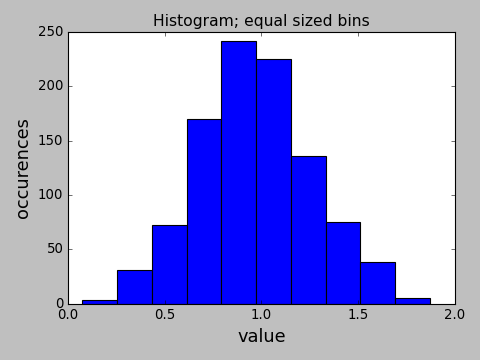

In [18]:
nbins = 10
low = np.mean(xstarSim) - 3*np.std(xstarSim)
high= np.mean(xstarSim) + 3*np.std(xstarSim)
plt.figure()
plt.xlabel("value")
plt.ylabel("occurences")
plt.title("Histogram; equal sized bins",fontsize=14)
out = plt.hist(xstarSim,nbins,[low,high])

## Uncertainties II: Using  the covariance matrix

#### Reminder

$$
\quad x^\ast = \frac{1}{m}(y^\ast - b)   
$$


#### Reminder warning

As mentioned above, the total uncertainty in the unknown $x^\ast$ is <em>not</em> given by adding all of the uncertainties in quadrature:

$$ 
\alpha_{x^\ast}^2 \neq \alpha_{y^\ast}^2 + \alpha_m^2 + \alpha_b^2. 
$$

Rather, it can be shown that the variance in $x^\ast$  is given by 

$$ 
\sigma_{x^\ast}^2 = 
   \left(\frac{\partial x^\ast}{\partial y^\ast}\sigma_{y^\ast}\right)^2 + \left[\left(\frac{\partial x^\ast}{\partial b}\sigma_b\right)^2+ 2\frac{\partial x^\ast}{\partial m}\frac{\partial x^\ast}{\partial b} \sigma_{bm} 
   + \left(\frac{\partial x^\ast}{\partial m}\sigma_m\right)^2 
    \right]   
    $$
    
where $\sigma_{bm}$ is the <em>covariance</em> between the correlated parameters 
$b$ and $m$ that is defined in Eq. (7.29) on p. 94 of Hughes and Hase.  The variances and the covariance in the square brackets can be collected in the <em>covariance matrix</em>:

$$  
\Sigma \equiv \left(\begin{array}{cc}
                        \sigma_b^2 & \sigma_{bm} \\
                        \sigma_{bm} & \sigma_m^2 
                        \end{array}\right)    ,
$$
                        
which is one of the things returned by the `curve_fit` function that implements the least square fitting procedure used above.  Writing 
the variance in the value of $\lambda^\ast$ in terms of the covariance matrix and 
the row vector $\nabla \lambda^\ast$, in which the derivatives are taken with respect to $b$ 
and $m$ and evaluated at the best fit values of these parameters, gives 

$$ 
\sigma_{x^\ast}^2 = 
   \left(\frac{\partial x^\ast}{\partial y^\ast}\right)^2\sigma^2_{y^\ast} 
   +  (\nabla x^\ast)\cdot \Sigma\cdot (\nabla x^\ast)^\text{T},  
$$
  
where $\nabla x^\ast$ is an array with the elements of gradient of $x^\ast$
with respect to the parameters $m$ and $b$, or 
  
$$
 \nabla x^\ast \longrightarrow 
   \left(\left.\frac{\partial x^\ast}{\partial b}\right|_{m_{\text{fit}},b_{\text{fit}}}, 
  \left.\frac{\partial x^\ast}{\partial m}\right|_{m_{\text{fit}},b_{\text{fit}}}\right).
$$

In this example the partial derivatives are easy to evaluate, but just for fun,
in the next cell I use the `numdifftools` module to calculate the derivatives numerically.

In [19]:
def f2(p):       # Function for calculation of lambda-star from b and m
    return (ystar-p[1])/p[0]

def f3(ystar):  # Same function, but ystar is the variable
    return (ystar-b)/m

In [20]:
best = np.array([m,b])
unc_p = nd.Derivative(f3)(ystar)*uystar
beta = nd.Gradient(f2)(best)          # Gradient of lambda-star evaluated at (b,m)
unc_mb = np.sqrt(beta@pcov_data@beta.T)    # As of python 3.5, @ symbol gives matrix multiplication
unc_xstar = np.sqrt(unc_p**2 + unc_mb**2)
print("The value of the unknown wavelength is", xstar, "+/-", unc_xstar)

The value of the unknown wavelength is 1.2373048413860441 +/- 0.3081888483691327


#### We get the same value of the uncertainty as we got using the simulations

$$
x^\ast = 1.2 \pm 0.3
$$

#### Version details
`version_information` is from J.R. Johansson (jrjohansson at gmail.com); see <a href='http://nbviewer.jupyter.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb'>Introduction to scientific computing with Python</a> for more information and instructions for package installation.

`version_information` is installed on the linux network at Bucknell

In [21]:
%load_ext version_information

In [22]:
%version_information numpy, scipy, numdifftools, matplotlib

Software versions
Python 3.7.8 64bit [GCC 7.5.0]
IPython 7.17.0
OS Linux 3.10.0 1062.9.1.el7.x86_64 x86_64 with centos 7.8.2003 Core
numpy 1.19.1
scipy 1.5.0
numdifftools 0.9.39
matplotlib 3.3.0
Thu Aug 20 16:22:57 2020 EDT